In [522]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import feather
from random import randint

#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns

# sklearn model imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, roc_curve, classification_report, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, jaccard_similarity_score,pairwise_distances, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.decomposition import LatentDirichletAllocation 

#Text models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 

#local imports
from xm_functions import *


InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option('display.float_format', lambda x: '%.3f' % x) #display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

### Quickly import our feather clean dataset

In [523]:
df = pd.read_feather('df_transformed_stackoverflow_posts.feather')
api_ressources_folder = 'OCR_Project6_StackOverFlow/API/ressources/'

In [524]:
pre_transform = '_LancasterStemmer'
# Get previously generated list of most important words (from lancaster)
df_important_words = pd.read_csv('important_words_l2'+pre_transform+'.csv')

In [525]:
df_tags_to_replace= pd.read_csv('tags_to_replace.csv').set_index('1')
final_tags_list =  set(df_tags_to_replace.index)

In [526]:
def filter_words(words, words_to_keep):
    if isinstance(words, str):
        words = np.array(words.split())
    if isinstance(words_to_keep, str):
        words_to_keep = np.array(words_to_keep.split())
        
    words_kept = np_str(words[np.in1d( words,  words_to_keep, assume_unique=False)])
    return words_kept

def replace_tags(x):
    tags = x.split(' ')
    replace_tags = set(tags) & final_tags_list
    if 'null' in tags:
        tags[tags.index('null')]=''
    for tag in replace_tags:
        tags[tags.index(tag)] = df_tags_to_replace.loc[tag].values[0]
    return np_str(tags)

In [527]:

df['body_ImportantWords'] = df['body'+pre_transform].apply(lambda x: filter_words(x, list(df_important_words['word'])))
df['title_ImportantWords'] = df['title'+pre_transform].apply(lambda x: filter_words(x, list(df_important_words['word'])))
print('Important words filtered')

df['new_tags'] = df['tags'].apply(replace_tags)
print('Secondary tags replaced')

Important words filtered
Secondary tags replaced


In [528]:
df.head(3)
df.shape

,title,body,tags,old_tags,body_LancasterStemmer,title_LancasterStemmer,old_body_LancasterStemmer,old_title_LancasterStemmer,body_ImportantWords,title_ImportantWords,new_tags
0,certain situations require use bitwise operato...,day trying code small c++ programming using sd...,c++,c++ event-handling sdl bitwise-operators boole...,day try cod smal c++ program us sdl libr ran s...,certain situ requir us bitw op instead log eq op,day try cod smal c++ program us sdl multimed l...,certain situ requir us bitw op instead log eq op,cod c++ program sdl libr ev er ev handl sdl co...,requir,c++
1,create channel youtube upload videos possible ...,using https github com youtube yt direct lite ...,ios objective-c,ios objective-c video youtube-data-api youtube...,us https github com youtub direct lit io sampl...,cre channel youtub upload video poss cre chann...,us https github com youtub yt direct lit io sa...,cre channel youtub upload video poss cre chann...,https github direct io channel new channel ap ...,cre channel cre channel program,ios objective-c
2,design decision boolean containsall collection...,boolean containsall collection c method collec...,java generics,java generics wildcard,bool collect c method collect framework allow ...,design decid bool collect c vs bool addal coll...,bool containsal collect c method collect frame...,design decid bool containsal collect c vs bool...,c method framework allow extend c allow extend...,c vs c framework,java generics


(43254, 11)

## Apply Pre transform to our posts, titles and tags

In [529]:
pre_transform = '_ImportantWords'
posts = df.loc[0:, 'body'+pre_transform]
posts_titles= df.loc[0:, 'title'+pre_transform]
posts_tags= df.loc[0:, 'new_tags']
posts_ids = df.index
nb_posts= posts_ids.shape[0]

### CountVectorizer of tags

In [530]:
min_occurences = round(nb_posts/1000)
# binary ensures repeated tags are counted once
countvector = CountVectorizer(min_df=min_occurences, binary =True, token_pattern ='[^\s]+')

# Apply fit_transform 
csrm_y = countvector.fit_transform(posts_tags)

tags_features = pd.Series([word for word in countvector.get_feature_names()])
y_features = [word for word in countvector.get_feature_names()]
df_y= pd.DataFrame(csrm_y.toarray(),index=posts_ids, columns=tags_features.values)

nb_tags_distinct=df_y.shape[1]
print(nb_tags_distinct,'distinct tags remaining. (', nb_posts,'posts )')

pd.DataFrame(y_features).to_csv(api_ressources_folder+'y_features.csv', index=False)


95 distinct tags remaining. ( 43254 posts )


### Tfidf of words in posts' body and title

In [531]:
# Create a TfidfVectorizer
vectorizer  = TfidfVectorizer( token_pattern ='[^\s]+')

# Apply fit_transform 
# Add post_titles *2 to add weight to titles and posts' body 
csrm_x = vectorizer.fit_transform(posts_titles+' '+posts_titles+' '+posts)

word_features = pd.Series([ word for word in vectorizer.get_feature_names()])
x_features = [word for word in vectorizer.get_feature_names()]
df_x = pd.DataFrame(csrm_x.toarray(),index=posts_ids, columns=word_features.values)

nb_words_distinct=df_x.shape[1]
print(nb_words_distinct,'distinct words remaining from title and body'+pre_transform ,'(', nb_posts,'posts )')
df_x.head(1)

pd.DataFrame(x_features).to_csv(api_ressources_folder+'x_features.csv', index=False)

942 distinct words remaining from title and body_ImportantWords ( 43254 posts )


,#,##,#define,#id,#include,access,accum,act,actionresult,activerecord,ad,adb,addclass,addeventl,adob,adt,aggreg,ajax,ajaxcontroltoolkit,ak,alamofir,alarm,alert,algorithm,align,...,wordpress,workbench,workflow,worksheet,wp,wpf,writelin,xamarin,xaml,xcod,xhtml,xib,xls,xml,xmlhttp,xmlhttprequest,xpa,xsl,xslt,xxxx,yi,yum,zend,zipcod,zygoteinit
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Supervised multi labels models


In [532]:
r_state = 42
X_train, X_test, y_train, y_test = train_test_split(csrm_x, csrm_y, test_size = 0.25, random_state=r_state )
np_items = df.index.values
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(np_items, np_items, test_size = 0.25, random_state=r_state  )

y_true_flat =y_test.toarray().flatten()

### Binary relevance <br>
Each target is treated as a separate classification problem

In [533]:
# initialize binary relevance multi-label classifier
classifier = BinaryRelevance(LinearSVC(C=1 , penalty='l2'))

print(X_train.shape[0], 'Items.', X_train.shape[1], 'features. ', y_test.shape[1], 'targets.')

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

y_pred_flat = predictions.toarray().flatten()

32440 Items. 942 features.  95 targets.


BinaryRelevance(classifier=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

In [534]:
from sklearn.metrics import recall_score, precision_score
recall_score(y_true_flat, y_pred_flat)

0.49973985431841833

In [481]:
hyperparams =[0.001, 0.01, 0.05, .1, .5, 1, 2, 4, 8]
df_h_tuning =pd.DataFrame(index = hyperparams, columns =['f1', 'recall', 'precision'])
for i in df_h_tuning.index:
    hyperp = i
    classifier = BinaryRelevance(LinearSVC(C=hyperp , penalty='l2'))
    classifier.fit(X_train, y_train)

    # predict
    predictions = classifier.predict(X_test)

    y_pred_flat = predictions.toarray().flatten()
    
    df_h_tuning.loc[i, 'f1'] = f1_score(y_true_flat, y_pred_flat)
    df_h_tuning.loc[i, 'recall'] = recall_score(y_true_flat, y_pred_flat)
    df_h_tuning.loc[i, 'precision'] = precision_score(y_true_flat, y_pred_flat)

BinaryRelevance(classifier=LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=4.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

BinaryRelevance(classifier=LinearSVC(C=8.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        require_dense=[True, True])

In [486]:
df_h_tuning

,f1,recall,precision
0.001,0.041,0.021,0.946
0.010,0.405,0.262,0.890
0.050,0.556,0.412,0.857
0.100,0.587,0.449,0.847
0.500,0.621,0.497,0.827
1.000,0.627,0.507,0.821
2.000,0.631,0.515,0.814
4.000,0.631,0.519,0.805
8.000,0.630,0.522,0.793


In [500]:
hyperparams
df_h_tuning.f1.values
df_h_tuning.index = df_h_tuning.index.map(str)

[0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 8]

array([0.04102616308663341, 0.4048556957954819, 0.5560632688927943,
       0.5872077215878195, 0.6207232673749878, 0.6267927197890539,
       0.6308579438656855, 0.6310062316135767, 0.6299874529485571],
      dtype=object)

In [511]:
df_h_tuning.unstack(1).reset_index()

,level_0,level_1,0
0,f1,0.001,0.041
1,f1,0.01,0.405
2,f1,0.05,0.556
3,f1,0.1,0.587
4,f1,0.5,0.621
5,f1,1.0,0.627
6,f1,2.0,0.631
7,f1,4.0,0.631
8,f1,8.0,0.630
9,recall,0.001,0.021


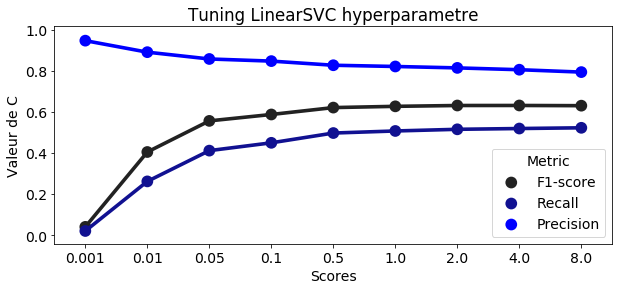

In [515]:
fig_size(10,4 ,14)
plt.rcParams['lines.linewidth'] = 2
df_h_tuning.columns =['F1-score', 'Recall', 'Precision']
df_h_tuning_restack = df_h_tuning.unstack().reset_index()
df_h_tuning_restack.columns = ['Metric', 'Score', 'C']
myplt = sns.pointplot('Score', 'C' , data =df_h_tuning_restack ,hue='Metric',color ='blue')
legend(myplt, 'Tuning LinearSVC hyperparametre', 'Scores', 'Valeur de C')

Binary relevance
roc_auc_score of : 0.7488045672282493
jaccard_similarity_score : 0.527324147709759
Adjusted Rand Score : 0.6074931231392202
Confusion matrix, without normalization
[[1005962    2148]
 [   9615    9605]]
              precision    recall  f1-score   support

           1       0.82      0.50      0.62     19220

   micro avg       0.82      0.50      0.62     19220
   macro avg       0.82      0.50      0.62     19220
weighted avg       0.82      0.50      0.62     19220



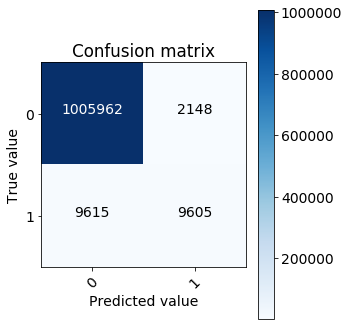

In [535]:
fig_size(5,5,14)
cm = confusion_matrix(y_true_flat, y_pred_flat, labels =[0,1])
print("Binary relevance")
print('roc_auc_score of :',roc_auc_score(y_true_flat, y_pred_flat))
print('jaccard_similarity_score :',jaccard_similarity_score(y_test, predictions))
print('Adjusted Rand Score :',adjusted_rand_score(y_true_flat, y_pred_flat))
plot_confusion_matrix(cm, [0,1])
print(classification_report(y_true_flat, y_pred_flat, labels = [1]))

In [327]:
y_test.shape
predictions.shape

full_report = classification_report(y_test, predictions, target_names=df_y.columns)
print(full_report)

(10814, 95)

(10814, 95)

                     precision    recall  f1-score   support

               .net       0.55      0.13      0.21       357
          algorithm       0.78      0.20      0.32       280
amazon-web-services       0.71      0.68      0.70        22
            android       0.96      0.79      0.87       789
            angular       0.88      0.79      0.83        76
          angularjs       0.89      0.68      0.77        98
             apache       0.55      0.18      0.27        91
             arrays       0.66      0.45      0.53       350
            asp.net       0.76      0.48      0.59       326
        asp.net-mvc       0.85      0.50      0.63       234
              azure       0.75      0.60      0.67        35
            browser       0.00      0.00      0.00        33
                  c       0.80      0.46      0.59       467
                 c#       0.81      0.54      0.65      1305
                c++       0.92      0.71      0.80       681
              class    

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted',

In [245]:
joblib.dump(classifier, 'OCR_Project6_StackOverFlow/API/ressources/binary_relevance_svc.pkl' )
joblib.dump(classifier, 'binary_relevance_svc.pkl' )

['OCR_Project6_StackOverFlow/API/ressources/binary_relevance_svc.pkl']

['binary_relevance_svc.pkl']

In [230]:
cm_square_full=confusion_matrix(y_test.toarray().argmax(axis=1), predictions.toarray().argmax(axis=1))

Confusion matrix, without normalization
[[579   1   5 ...   0   3   1]
 [ 15  12   0 ...   0   0   0]
 [ 97   0  43 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [ 23   0   0 ...   0  16   0]
 [  4   0   0 ...   0   0  11]]


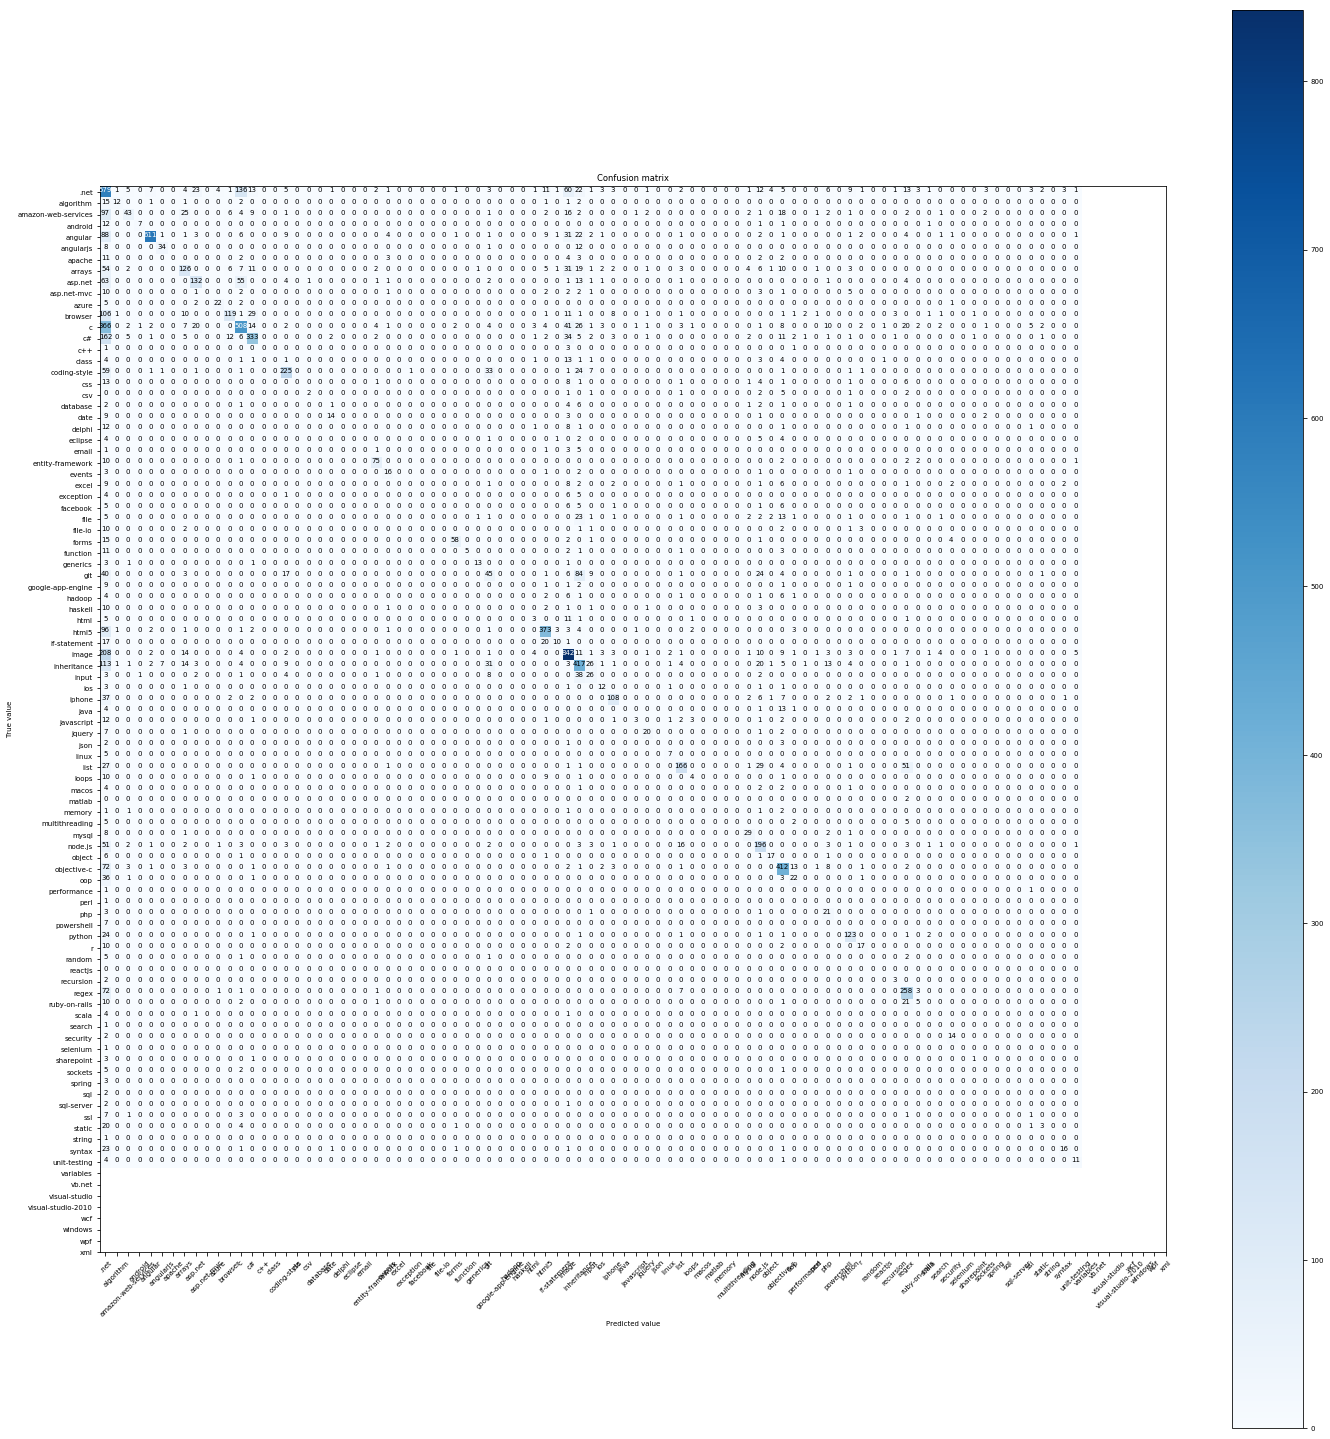

In [209]:
fig_size(20,20, 7)
plot_confusion_matrix(cm_square_full,  df_y.columns)

In [464]:
rand_ex = randint(0, y_test.shape[0]) 
index_ex = y_test_i[rand_ex]
true_ex = tags_features[pd.Series(y_test[rand_ex].toarray().flatten(), index = tags_features.values).nonzero()[0]]
pred_ex = tags_features[pd.Series(predictions[rand_ex].toarray().flatten(), index = tags_features.values).nonzero()[0]]

pd.DataFrame(df_x.iloc[index_ex, df_x.loc[index_ex].nonzero()[0]]).T
print('Kept tags :',  true_ex.values)
print('Predicted tags :',pred_ex.values)
df.loc[index_ex]
df.loc[index_ex, 'body']

,az,er,giv,right,serv,studio,vert,vis
16635,0.314,0.348,0.149,0.176,0.589,0.434,0.170,0.405


Kept tags : ['azure']
Predicted tags : ['visual-studio']


title                         error wat default service configuration servic...
body                          installing visual studio enterprise version az...
tags                                                                      azure
old_tags                          azure visual-studio-2017 azure-cloud-services
body_LancasterStemmer         instal vis studio enterpr vert az cloud serv l...
title_LancasterStemmer           er wat default serv config could found project
old_body_LancasterStemmer     instal vis studio enterpr vert az cloud serv l...
old_title_LancasterStemmer    er wat default serv config serviceconfig cscfg...
body_ImportantWords           vis studio vert az serv giv er serv vis studio...
title_ImportantWords                                                    er serv
new_tags                                                                  azure
Name: 16635, dtype: object

'installing visual studio enterprise version azure cloud service longer build gives error wat default service configuration serviceconfiguration cscfg could found project although still works fine visual studio enterprise right targetprofile also specified'

### Classifier Chains <br>
Include targets in data

In [246]:
classifier = ClassifierChain(LinearSVC())
print(X_train.shape[0], 'Items.', X_train.shape[1], 'features. ', y_test.shape[1], 'targets.')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
y_pred_flat = predictions.toarray().flatten()


32440 Items. 942 features.  95 targets.


ClassifierChain(classifier=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        order=None, require_dense=[True, True])

In [250]:
y_test.shape

(10814, 95)


roc_auc_score of : 0.757319169630034
jaccard_similarity_score : 0.5422415387460698
Adjusted Rand Score : 0.6181356351842224
Confusion matrix, without normalization
[[1005768    2342]
 [   9284    9936]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1008110
           1       0.81      0.52      0.63     19220

   micro avg       0.99      0.99      0.99   1027330
   macro avg       0.90      0.76      0.81   1027330
weighted avg       0.99      0.99      0.99   1027330



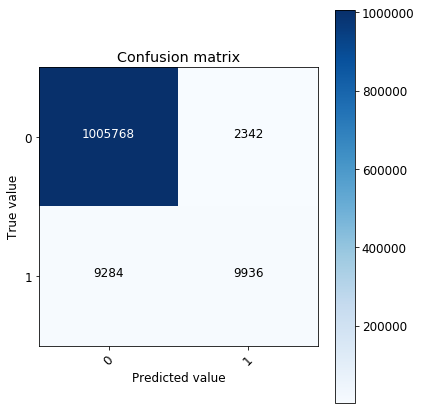

In [251]:
cm = confusion_matrix(y_true_flat, y_pred_flat, labels =[0,1])
print("")
print('roc_auc_score of :',roc_auc_score(y_true_flat, y_pred_flat))
print('jaccard_similarity_score :',jaccard_similarity_score(y_test, predictions))
print('Adjusted Rand Score :',adjusted_rand_score(y_true_flat, y_pred_flat))
plot_confusion_matrix(cm, [0,1])
print(classification_report(y_true_flat, y_pred_flat, labels = [0,1]))

In [248]:
rand_ex = randint(0, y_test.shape[0]) 
index_ex = y_test_i[rand_ex]
true_ex = tags_features[pd.Series(y_test[rand_ex].toarray().flatten(), index = tags_features.values).nonzero()[0]]
pred_ex = tags_features[pd.Series(predictions[rand_ex].toarray().flatten(), index = tags_features.values).nonzero()[0]]

print(rand_ex)
pd.DataFrame(df_x.iloc[index_ex, df_x.loc[index_ex].nonzero()[0]]).T
print('Kept tags :',  true_ex.values)
print('Predicted tags :',pred_ex.values)
df.loc[index_ex]
df.loc[index_ex, 'body']

1287


,x_array,x_c,x_funct,x_javascrib,x_leng,x_multidimend,x_splice,x_var
21374,0.611,0.077,0.266,0.095,0.410,0.571,0.200,0.087


Kept tags : ['y_javascript']
Predicted tags : ['y_arrays' 'y_javascript']


title                         write function splits array first argument gro...
body                          working javascript problem asks write function...
tags                                                                 javascript
old_tags                                                             javascript
body_LancasterStemmer         work javascrib problem ask writ funct array fi...
title_LancasterStemmer        writ funct array first argu group leng siz sec...
old_body_LancasterStemmer     work javascrib problem ask writ funct splits a...
old_title_LancasterStemmer    writ funct splits array first argu group leng ...
body_ImportantWords           javascrib funct array leng multidimend array a...
title_ImportantWords                         funct array leng multidimend array
new_tags                                                             javascript
Name: 21374, dtype: object

'working javascript problem asks write function splits array first argument groups length size second argument returns multidimensional array example input chunk return chunked arrays get work examples chunks switches order sure code written function chunk arr size var newarray temp arr arr length size i+ size newarray push arr slice i+size temp splice size newarray push temp return newarray chunk b c'

## Evaluate performance without using tags

In [256]:
def compute_similarity(df_x, min_similar = 0, evaluation_matrice = csrm_x) :
    nb_groups = df_x.shape[1]
    df_group_dists =pd.DataFrame(np.zeros((nb_groups,2)),index =  range(nb_groups), columns=['avg_dist', 'group_size'])

    for group_i in  range(nb_groups):
        group_csrm = evaluation_matrice[list(df_x.iloc[:,group_i][df_x.iloc[:,group_i]>min_similar ].index.values)]
        group_size = group_csrm.shape[0]
        for post_i in range(group_size):
            df_group_dists.loc[group_i, 'avg_dist']+= np.mean(pairwise_distances(group_csrm[post_i], group_csrm, metric ='euclidean'))

        df_group_dists.loc[group_i, 'group_size'] = group_size
    df_group_dists['avg_dist'] = df_group_dists['avg_dist']/df_group_dists['group_size']
    return df_group_dists.fillna(0)

In [257]:
df_tags_true_dist = compute_similarity(df_y, evaluation_matrice = csrm_y)
df_tags_true_dist.mean()

avg_dist       1.407
group_size   811.168
dtype: float64

In [258]:

predictions = classifier.predict(csrm_x)
df_pred = pd.DataFrame(predictions.toarray(), columns = df_y.columns, index =df_y.index )

df_tags_pred_dist = compute_similarity(df_pred, evaluation_matrice = csrm_y)
df_tags_pred_dist.mean()

avg_dist       1.103
group_size   531.895
dtype: float64

## Unsupervised models

## LDA - LatentDirichletAllocation

In [337]:
lda = LatentDirichletAllocation(n_components  = 95)

In [338]:
print(df_x.shape[0], 'Items.', df_x.shape[1], 'features. ')

# train
lda_results = lda.fit_transform(df_x.values)


43254 Items. 942 features. 


In [347]:
df_lda = pd.DataFrame(lda_results, index = df_x.index)

In [448]:
df_random = df_lda.sample(frac=1).reset_index(drop=True)

In [348]:
if 'lda_dist_means' not in locals():
    df_lda_groups_dists  = pd.DataFrame()
    for i in range(1,10):
        i=i/10
        df_lda_groups_dists[['avg_dist_'+str(i), 'group_size_'+str(i)]] = compute_similarity(df_lda, min_similar = i, evaluation_matrice = csrm_y)
    
    lda_dist_means = df_lda_groups_dists.mean()
    
df_lda_dist_means = pd.DataFrame()
for i in range(1,10):
    i=i/10
    df_lda_dist_means.loc[i, 'Seuil'] = i
    df_lda_dist_means.loc[i, 'avg_dist'] = lda_dist_means['avg_dist_'+str(i)]
    df_lda_dist_means.loc[i, 'avg_group_size'] = lda_dist_means['group_size_'+str(i)]

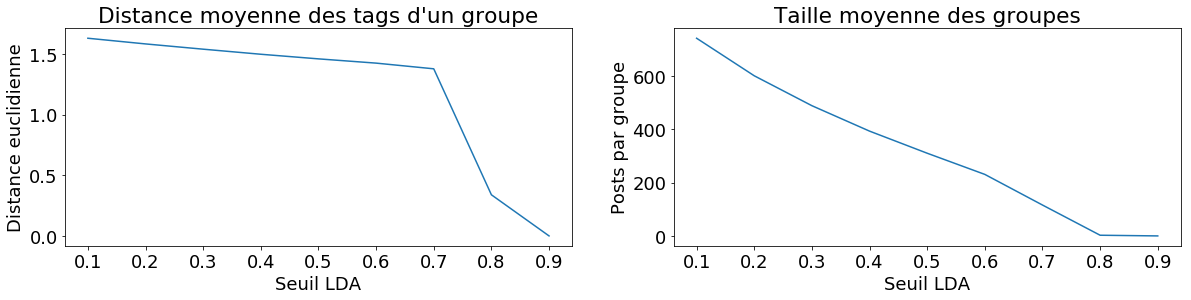

In [349]:
fig_size(20,4)
fig, axes  = plt.subplots(1, 2, sharey=False, sharex=False)

sns.lineplot('Seuil', 'avg_dist' , data = df_lda_dist_means, ax = axes[0])
legend(axes[0], 'Distance moyenne des tags d\'un groupe','Seuil LDA', 'Distance euclidienne' )
sns.lineplot('Seuil', 'avg_group_size' , data = df_lda_dist_means, ax = axes[1])
legend(axes[1], 'Taille moyenne des groupes','Seuil LDA', 'Posts par groupe' )

In [359]:
seuil = 0.3
df_lda_groups_dists['avg_dist'] = df_lda_groups_dists['avg_dist_'+str(seuil)]
df_lda_groups_dists['group_size'] = df_lda_groups_dists['group_size_'+str(seuil)]
df_lda_groups_dists['group_size'].mean()
df_lda_groups_dists['avg_dist'].mean()

487.8

1.5390288765049296

In [361]:
seuil = 0.25
df_lda_groups_dists = compute_similarity(df_lda, min_similar = seuil, evaluation_matrice = csrm_y)
df_lda_groups_dists['group_size'].mean()
df_lda_groups_dists['avg_dist'].mean()

541.6421052631579

1.5597267567318847

In [449]:
seuil = 0.25
df_rand_groups_dists = compute_similarity(df_random, min_similar = seuil, evaluation_matrice = csrm_y)
df_rand_groups_dists['group_size'].mean()
df_rand_groups_dists['avg_dist'].mean()

541.6421052631579

1.7874753823059522

In [442]:
def trace_mean(plt, dist_series, max_ = 0):
    mean_val = dist_series.mean()
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=1)
    
    if max_==0 and plt.__class__.__name__ == 'AxesSubplot':
        max_ = plt.get_yticks()[-2]
    elif max_==0 :
        max_ = plt.get_yticks()[-2]
    plt.text(mean_val-0.09*plt.get_xticks()[-1],max_, 'Mean  {:.2f}'.format(mean_val))


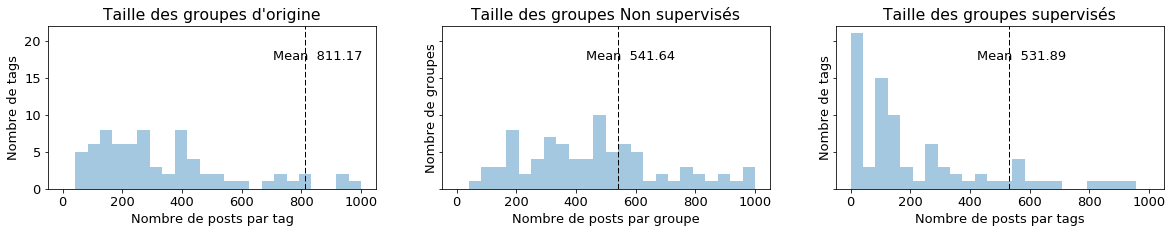

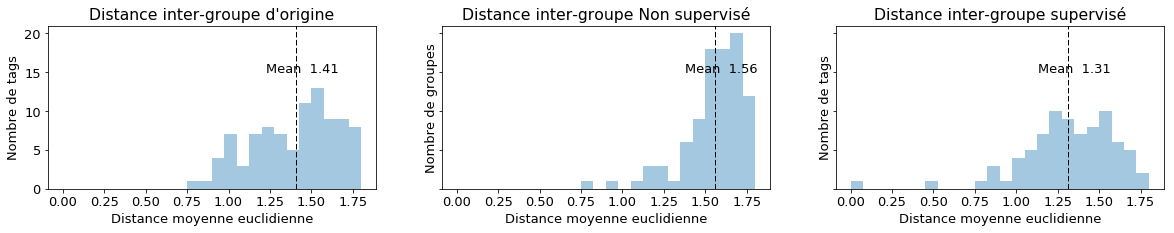

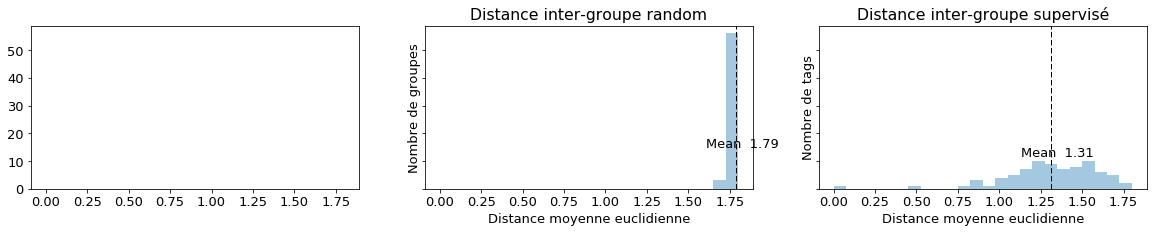

In [462]:
fig_size(20,3,13)

df_column = 'group_size'
fig, axes  = plt.subplots(1, 3, sharey=True, sharex=True)
silent = sns.distplot(df_tags_true_dist[df_column], kde=False, ax = axes[0], bins = np.linspace(0,1000, 25))
trace_mean(axes[0], df_tags_true_dist[df_column], 17.5)
legend(axes[0] , 'Taille des groupes d\'origine', 'Nombre de posts par tag', 'Nombre de tags')

silent = sns.distplot(df_lda_groups_dists[df_column], kde=False, ax = axes[1], bins = np.linspace(0,1000, 25))
trace_mean(axes[1], df_lda_groups_dists[df_column], 17.5)
legend(axes[1] , 'Taille des groupes Non supervisés', 'Nombre de posts par groupe', 'Nombre de groupes')

silent = sns.distplot(df_tags_pred_dist[df_column], kde=False, ax = axes[2], bins = np.linspace(0,1000, 25))
trace_mean(axes[2], df_tags_pred_dist[df_column], 17.5)
legend(axes[2] , 'Taille des groupes supervisés', 'Nombre de posts par tags', 'Nombre de tags')

plt.show()
fig_size(20,3,13)
df_column = 'avg_dist'
fig, axes  = plt.subplots(1, 3, sharey=True, sharex=True)
silent = sns.distplot(df_tags_true_dist[df_column], kde=False, ax = axes[0], bins = np.linspace(0,1.8, 25))
trace_mean(axes[0], df_tags_true_dist[df_column], 15)
legend(axes[0] , 'Distance inter-groupe d\'origine', 'Distance moyenne euclidienne', 'Nombre de tags')

silent = sns.distplot(df_lda_groups_dists[df_column], kde=False, ax = axes[1], bins = np.linspace(0,1.8, 25))
trace_mean(axes[1], df_lda_groups_dists[df_column], 15)
legend(axes[1] , 'Distance inter-groupe Non supervisé', 'Distance moyenne euclidienne', 'Nombre de groupes')

silent = sns.distplot(df_tags_pred_dist[df_column][df_tags_pred_dist.group_size>0], kde=False, ax = axes[2], bins = np.linspace(0,1.8, 25))
trace_mean(axes[2], df_tags_pred_dist[df_column][df_tags_pred_dist.group_size>0], 15)
legend(axes[2] , 'Distance inter-groupe supervisé', 'Distance moyenne euclidienne', 'Nombre de tags')
plt.show()

df_column = 'avg_dist'
fig, axes  = plt.subplots(1, 3, sharey=True, sharex=True)

silent = sns.distplot(df_rand_groups_dists[df_column], kde=False, ax = axes[1], bins = np.linspace(0,1.8, 25))
trace_mean(axes[1], df_rand_groups_dists[df_column], 15)
legend(axes[1] , 'Distance inter-groupe random', 'Distance moyenne euclidienne', 'Nombre de groupes')


silent = sns.distplot(df_tags_pred_dist[df_column][df_tags_pred_dist.group_size>0], kde=False, ax = axes[2], bins = np.linspace(0,1.8, 25))
trace_mean(axes[2], df_tags_pred_dist[df_column][df_tags_pred_dist.group_size>0], 11.5)
legend(axes[2] , 'Distance inter-groupe supervisé', 'Distance moyenne euclidienne', 'Nombre de tags')
plt.show()
